<a href="https://colab.research.google.com/github/AliaksandrSiarohin/articulated-animation/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Demo for paper "Motion Representations for Articulated Animation"
**Clone repository. First install git lfs. Pulling all checkpoints may take a while**


**Load source image and driving video.**

In [1]:
import imageio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings

# from re_demo import load_checkpoints

import sys
import yaml
from tqdm import tqdm

from skimage.transform import resize
from skimage import img_as_ubyte
import torch
from sync_batchnorm import DataParallelWithCallback
from modules.generator import Generator
from modules.region_predictor import RegionPredictor
from modules.avd_network import AVDNetwork
from animate import get_animation_region_params
import matplotlib
matplotlib.use('Agg')
import pickle as pkl

warnings.filterwarnings("ignore")
dataset = 'ted'
# source_name = f"data/{dataset}/img_00000027.jpg" # "Hitmonchan"
source_name = f"../prepare_data/deepFashion/img_highres/2-in-1_Space_Dye_Athletic_Tank/img_00000005.jpg"
source_image = resize(imageio.imread(source_name), (1024, 1024))[..., :3]

driving_video = imageio.mimread(f'data/{dataset}/driving1.mp4')

video_shape = (384, 384) if dataset=='ted' else (256, 256)
# video_shape = (64, 64)
source_image256 = resize(source_image, video_shape)[..., :3]

driving_video = [resize(frame, video_shape)[..., :3] for frame in driving_video]
print(source_image.shape, source_image256.shape)

(1024, 1024, 3) (384, 384, 3)


In [2]:

if sys.version_info[0] < 3:
    raise Exception("You must use Python 3 or higher. Recommended version is Python 3.7")


def load_checkpoints(config_path, checkpoint_path, cpu=False):
    with open(config_path) as f:
        config = yaml.safe_load(f)

    generator = Generator(num_regions=config['model_params']['num_regions'],
                          num_channels=config['model_params']['num_channels'],
                          **config['model_params']['generator_params'])
    if not cpu:
        generator.cuda()

    region_predictor = RegionPredictor(num_regions=config['model_params']['num_regions'],
                                       num_channels=config['model_params']['num_channels'],
                                       estimate_affine=config['model_params']['estimate_affine'],
                                       **config['model_params']['region_predictor_params'])
    
    if not cpu:
        region_predictor.cuda()

    avd_network = AVDNetwork(num_regions=config['model_params']['num_regions'],
                             **config['model_params']['avd_network_params'])
    if not cpu:
        avd_network.cuda()

    if cpu:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)
    

    generator.load_state_dict(checkpoint['generator'])
    region_predictor.load_state_dict(checkpoint['region_predictor'])
    if 'avd_network' in checkpoint:
        avd_network.load_state_dict(checkpoint['avd_network'])

    if not cpu:
        generator = DataParallelWithCallback(generator)
        region_predictor = DataParallelWithCallback(region_predictor)
        avd_network = DataParallelWithCallback(avd_network)

    generator.eval()
    region_predictor.eval()
    avd_network.eval()

    return generator, region_predictor, avd_network
generator, region_predictor, avd_network = load_checkpoints(config_path=f'config/{dataset}{video_shape[0]}.yaml',
                                                            checkpoint_path=f'checkpoints/{dataset}{video_shape[0]}.pth')
# region_predictor = load_checkpoints(config_path=f'config/{dataset}{video_shape[0]}.yaml',
                                                            # checkpoint_path=f'checkpoints/{dataset}{video_shape[0]}.pth')

**Perform animation.**

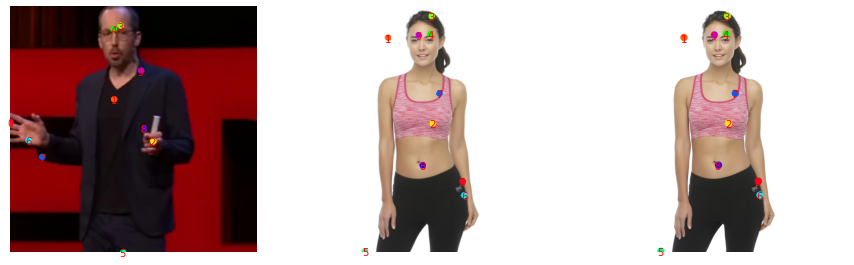

In [3]:
%matplotlib inline
from skimage import img_as_ubyte


def make_animation(source_image, driving_video, generator, region_predictor, avd_network,
                   animation_mode='standard', cpu=False):
    with torch.no_grad():
        predictions = []
        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source = source.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
        source_region_params = region_predictor(source)
        driving_region_params = region_predictor(driving[:, :, 0]) # First frame

    return source_region_params, driving_region_params


from skimage.draw import disk

kp_size = 5
draw_border = True
colormap = plt.get_cmap('gist_rainbow')
region_bg_color = [1, 1, 1]

def draw_image_with_kp(image, ax, kp_array, kp_size):
    
    image = np.copy(image)
    spatial_size = np.array(image.shape[:2][::-1])[np.newaxis]
    kp_array = spatial_size * (kp_array + 1) / 2
    num_regions = kp_array.shape[0]
    for kp_ind, kp in enumerate(kp_array):
        rr, cc = disk((kp[1], kp[0]), kp_size, shape=image.shape[:2])
        ax.text(kp[0], kp[1], f"{kp_ind}", dict(color='red', va='center', ha='center'))
        image[rr, cc] = np.array(colormap(kp_ind / num_regions))[:3]
    ax.imshow(image)
    ax.axis('off')
    return image

source_region_params, driving_region_params = make_animation(source_image, driving_video, generator, 
                             region_predictor, avd_network, animation_mode='avd')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
draw_image_with_kp(driving_video[0], axs[0], driving_region_params['shift'][0].data.cpu().numpy(), kp_size=5)
draw_image_with_kp(source_image256, axs[1], source_region_params['shift'][0].data.cpu().numpy(), kp_size=5)
draw_image_with_kp(source_image, axs[2], source_region_params['shift'][0].data.cpu().numpy(), kp_size=15)

plt.show()

## Optical Flow Visualization

In [32]:
import cv2
import numpy as np
import torch.nn.functional as F

from torchvision import transforms 
from PIL import ImageFont, ImageDraw


    
def add_annotation(img, annotation, font_scale):
    if font_scale:
        scale = 4
    else:
        scale = 1
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", int(60//scale)) # default font directory of ubuntu
    img = torch.Tensor(img)
    img = img.permute(2, 0, 1) if img.shape[0]!=3 else img

    img_ = transforms.ToPILImage()(img) # C, H, W
    draw = ImageDraw.Draw(img_)
    draw.text((60/scale, 30/scale), annotation, font=font, fill=(190, 80, 120, 255))
    img_ = transforms.ToTensor()(img_) # C, H, W
    return img_.numpy().transpose(1, 2, 0) # C, H, W


def optical_flow_ang(flow, occlusion, font_scale, shape=(256, 256, 3)):
    hsv = np.zeros(shape, dtype=np.uint8)
    hsv[..., 1] = 255
    flow = flow.squeeze(0).permute(2, 0, 1).numpy()
    occlusion = occlusion.squeeze(0)
    occlusion = np.concatenate((occlusion, occlusion, occlusion), axis=0)
    # scale = shape[0]/flow.shape[1]
    # if scale!=1:
    #     flow = flow.permute(0, 3, 1, 2)
    #     flow = F.interpolate(flow, scale_factor=scale, mode='bilinear').squeeze(0).numpy()
    #     occlusion = F.interpolate(occlusion, scale_factor=scale, mode='bilinear').squeeze(0)
    #     occlusion = occlusion.permute(1, 2, 0).numpy()
    #     
    mag, ang = cv2.cartToPolar(flow[0, ...], flow[1, ...])
    hsv[..., 0] = ang * 180/ np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    of = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    occlusion = add_annotation(occlusion, 'occlusion mask', font_scale=font_scale) # C, H, W
    return of, occlusion

In [33]:
from torchvision.utils import save_image
import torch.nn.functional as F
import numpy as np
import pickle

def make_animation(source_image256, source_image512, driving_video, generator, region_predictor, avd_network, dataset, scale,
                   animation_mode='standard', ground_truth=None, cpu=False, keypoints=None):

    out = None
    
    with torch.no_grad():
        predictions = []

        # Compute keypoints, affine transformation from 256 resolution
        source_image256 = source_image256
        source256 = torch.tensor(source_image256[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source256 = source256.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)

        # TODO: Add keypoints manually
        if keypoints is not None:
            pass
        else:
            keypoints = None

        source_region_params = region_predictor(source256, keypoints)
        driving_region_params_initial = region_predictor(driving[:, :, 0])

        source512 = torch.tensor(source_image512[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source512 = source512.cuda()
        for frame_idx in tqdm(range(driving.shape[2])):
            driving_frame = driving[:, :, frame_idx]
            if not cpu:
                driving_frame = driving_frame.cuda()
            driving_region_params = region_predictor(driving_frame)
            
            new_region_params = get_animation_region_params(source_region_params, driving_region_params,
                                                            driving_region_params_initial, avd_network=avd_network,
                                                            mode=animation_mode)
            
            out = generator(source256, source512, source_region_params=source_region_params, driving_region_params=new_region_params)
            # deformed: torch.Size([1, 3, 1024, 1024])
            # optical_flow: torch.Size([1, 1024, 1024, 2])
            # occlusion_map: torch.Size([1, 1, 1024, 1024])
            # prediction: torch.Size([1, 3, 1024, 1024])
            res = out['prediction'].shape[-1]
            of, om = optical_flow_ang(out['optical_flow'].detach().cpu(), out['occlusion_map'].detach().cpu(), font_scale=scale, shape=(res, res, 3))
            
            deformed = add_annotation(out['deformed'].cpu()[0], 'deformed source', font_scale=scale)
            pred = add_annotation(out['prediction'].cpu()[0], 'inpainted', font_scale=scale)
            # deformed = np.transpose(out['deformed'].data.cpu().numpy(), [0, 2, 3, 1])[0]
            # pred = np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0]
            predictions.append(np.concatenate([deformed, pred, om, of/255], axis=1))
        return predictions



In [36]:
original = source_image256
hr = source_image256
scale = (hr.shape[0]/original.shape[0])**2
if int(scale)==1:
        scale=True
print(scale)
print(f"Trained with {original.shape}, Infer with {hr.shape}")
predictions = make_animation(original, hr,
        driving_video, generator, region_predictor, 
        avd_network, dataset, scale=scale, animation_mode='avd')

True
Trained with (384, 384, 3), Infer with (384, 384, 3)


100%|██████████| 160/160 [00:11<00:00, 13.65it/s]


In [35]:
imageio.mimsave(f'{dataset}_orig{original.shape[0]}_hr{hr.shape[0]}.mp4', [(frame*255).astype(np.uint8) for frame in predictions])

# EDGE Detection

In [ ]:
%matplotlib inline
from canny_edge_detector import canny_edge_detector as ced
from PIL import Image, ImageFilter

  
# Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
image = image.filter(ImageFilter.FIND_EDGES)
img_np = np.array(image)
# Saving the Image Under the name Edge_Sample.png
image.save(r"Edge_Sample.png")
image = Image.open(source_name)
image = image.convert("L")
image_np = np.array(image)
print(image_np.shape)
detector = ced.cannyEdgeDetector([image_np], sigma=1.4, kernel_size=5, lowthreshold=0.1, highthreshold=0.1, weak_pixel=10)
imgs_final = detector.detect()